# Import libraries and mount drive

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fft2, ifft2
import torchvision
import torchvision.transforms as T
from torchvision import io
from torch.utils.data import Dataset, DataLoader

import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
## Install and import torch metrics
!pip install torchmetrics -q
import torchmetrics

In [ ]:
!rm DeconvModels.py
!rm training_functions.py
!rm blur_functions.py
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/Models/DeconvModels.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/util/training_functions.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/util/blur_functions.py -q
from DeconvModels import Deconv2D
from training_functions import train_regression_model, train_classification_model
import blur_functions as blur

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/data/kaggle-sir/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Class and create dataloader

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, ds_path):
        self.ds_path = ds_path

        y_imgs = os.listdir(f'{ds_path}/HR')[:20]


        self.y_paths = list(map(lambda img_path: f'{ds_path}/HR/{img_path}', y_imgs))
        self.x_paths = list(map(lambda img_path: f'{ds_path}/LR/{img_path}', y_imgs))

    
    def __len__(self):
        return len(self.y_paths)


    def __getitem__(self, idx):
        y_path = self.y_paths[idx]
        x_path = self.x_paths[idx]

        # x_img = io.read_image(x_path, io.ImageReadMode.GRAY)
        y_img = io.read_image(y_path, io.ImageReadMode.GRAY)
        x_img = io.read_image(x_path, io.ImageReadMode.GRAY)

        SIZE = 384
        PAD_SIZE = SIZE//8

        # Preprocess image
        y_img = T.Resize((SIZE, SIZE))(y_img)
        y_img = y_img / 255.0
        y_img = nn.functional.pad(y_img, (PAD_SIZE, PAD_SIZE, PAD_SIZE, PAD_SIZE))

        # Preprocess image
        x_img = T.Resize((SIZE, SIZE))(x_img)
        x_img = x_img / 255.0
        x_img = nn.functional.pad(x_img, (PAD_SIZE, PAD_SIZE, PAD_SIZE, PAD_SIZE))

        return x_img, y_img

In [ ]:
data = ImageDataset(base_path)
dataloader = DataLoader(data, batch_size=8, shuffle=False)

x_batch, y_batch = next(iter(dataloader))

x_batch.size(), y_batch.size()

(torch.Size([8, 1, 480, 480]), torch.Size([8, 1, 480, 480]))

(-0.5, 479.5, 479.5, -0.5)

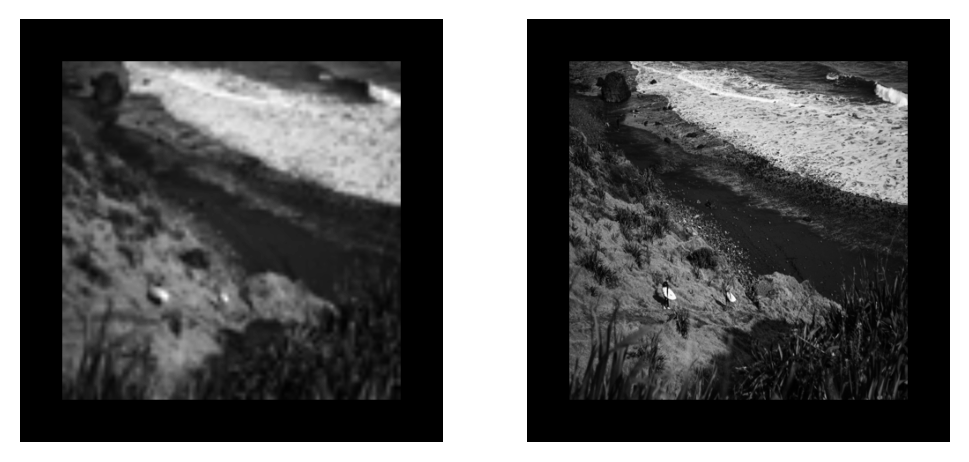

In [ ]:
plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.imshow(x_batch[0, 0, :, :], cmap='gray')
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(y_batch[0, 0, :, :], cmap='gray')
plt.axis(False)

# Initialise Model, Criterion, Optimizer

In [ ]:
model = Deconv2D((2, 4))

model = model.to(device)

criterion = torchmetrics.StructuralSimilarityIndexMeasure()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train model

In [ ]:
def train_regression_model(model: nn.Module, criterion, optimizer, dataloader, num_epochs=3, deconv=False):
    """
        Trains NN regression on datasets for deblurring and super image resolution
        :param model: The NN model that you would like to train must be of type nn.Module
        :param criterion: The loss function that you would like to use
        :param optimizer: The optimizer that will optimize the NN
        :param dataloader: Dataloader that loads data from classification dataset
        :param num_epochs: Number of times you want to train the data over
        :param deconv: boolean check whether to save deconv kernel or not
        :return: A dictionary containing training loss for each epoch
        and list of the kernels after each epoch if the model is a deconv layer
    """
    print('Using this function')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    if num_epochs > 20:
        print_epoch_every = num_epochs // 20
    else:
        print_epoch_every = 1
    history = {'loss': []}
    kernel_history = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            with torch.set_grad_enabled(True):
                outputs = model(X)
                loss = 1 - criterion(outputs, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item()

        if deconv:
            w = nn.functional.pad(model.w_flat, (1, 0), value=1)
            w = torch.reshape(w, model.h_shape)
            kernel_history.append(w.numpy())

        history['loss'].append(running_loss)
        if (epoch + 1) % print_epoch_every == 0:
            print('Epoch {:04d} loss: {:.5f}'.format(epoch + 1, running_loss))

    return history, kernel_history

In [ ]:
history, _ = train_regression_model(model, criterion, optimizer, dataloader, num_epochs=200)

Using this function
Epoch 0010 loss: 0.59907
Epoch 0020 loss: 0.55811
Epoch 0030 loss: 0.50568
Epoch 0040 loss: 0.46745
Epoch 0050 loss: 0.43766
Epoch 0060 loss: 0.40924
Epoch 0070 loss: 0.38641
Epoch 0080 loss: 0.38357
Epoch 0090 loss: 0.38225
Epoch 0100 loss: 0.38073
Epoch 0110 loss: 0.37894
Epoch 0120 loss: 0.37669
Epoch 0130 loss: 0.37364
Epoch 0140 loss: 0.36912
Epoch 0150 loss: 0.36177
Epoch 0160 loss: 0.32019
Epoch 0170 loss: 0.24665
Epoch 0180 loss: 0.16456
Epoch 0190 loss: 0.10469
Epoch 0200 loss: 0.09454


# Plot results

In [ ]:
print(model.w_flat)

Parameter containing:
tensor([ 0.1298,  0.0097, -0.0103, -0.4481,  0.2044,  0.0944,  0.0211],
       device='cuda:0', requires_grad=True)


Text(0.5, 1.0, 'Original')

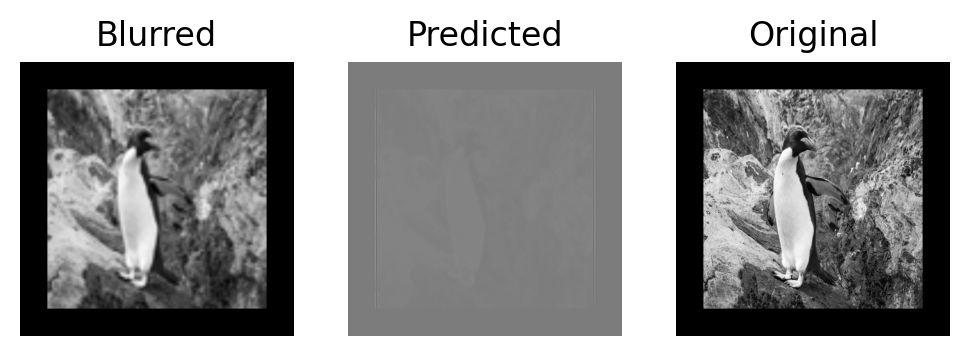

In [ ]:
model = model.to("cpu")
model.eval()
X, y = next(iter(dataloader))

y_pred = model(X)

import random

plt.rcParams['figure.dpi'] = 200
# plt.figure(figsize=(40, 120))

i = random.randint(0, len(X)-1)

start = X.size(-1)//4
end = 3*start

plt.subplots(1, 3)

plt.subplot(1, 3, 1)
plt.imshow(X[i,0,:,:], cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[i,0,:,:].detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted')

plt.subplot(1, 3, 3)
plt.imshow(y[i,0,:,:], cmap='gray')
plt.axis('off')
plt.title('Original')

# Testing Conv model

In [ ]:
model_conv = nn.Conv2d(1, 1, 3, padding='same')

model_conv = model_conv.to(device)

criterion = torchmetrics.StructuralSimilarityIndexMeasure()
criterion = criterion.to(device)

optimizer = optim.Adam(model_conv.parameters(), lr=1e-3)

In [ ]:
history_conv, _ = train_regression_model(model_conv, criterion, optimizer, dataloader, num_epochs=200)

Using this function
Epoch 0010 loss: 1.84212
Epoch 0020 loss: 1.09499
Epoch 0030 loss: 0.85879
Epoch 0040 loss: 0.74135
Epoch 0050 loss: 0.67961
Epoch 0060 loss: 0.65462
Epoch 0070 loss: 0.64356
Epoch 0080 loss: 0.63802
Epoch 0090 loss: 0.63475
Epoch 0100 loss: 0.63243
Epoch 0110 loss: 0.63049
Epoch 0120 loss: 0.62865
Epoch 0130 loss: 0.62685
Epoch 0140 loss: 0.62501
Epoch 0150 loss: 0.62311
Epoch 0160 loss: 0.62116
Epoch 0170 loss: 0.61916
Epoch 0180 loss: 0.61712
Epoch 0190 loss: 0.61502
Epoch 0200 loss: 0.61288


Text(0.5, 1.0, 'Original')

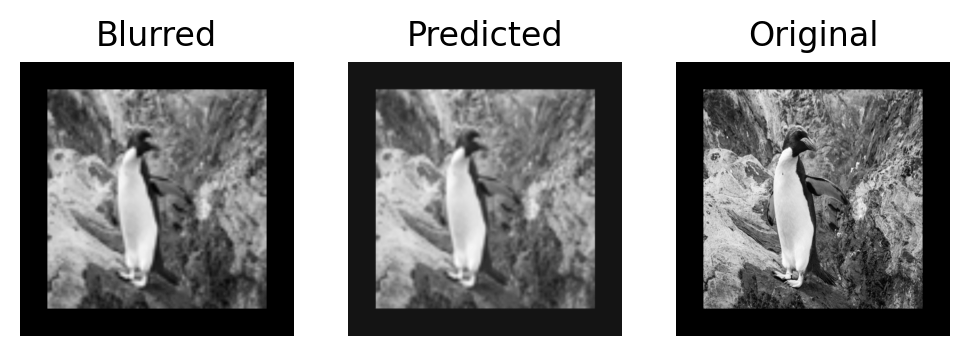

In [ ]:
model_conv = model_conv.to("cpu")
model_conv.eval()
X, y = next(iter(dataloader))

y_pred = model_conv(X)

import random

plt.rcParams['figure.dpi'] = 200
# plt.figure(figsize=(40, 120))

# i = random.randint(0, len(X)-1)

start = X.size(-1)//4
end = 3*start

plt.subplots(1, 3)

plt.subplot(1, 3, 1)
plt.imshow(X[i,0,:,:], cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[i,0,:,:].detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted')

plt.subplot(1, 3, 3)
plt.imshow(y[i,0,:,:], cmap='gray')
plt.axis('off')
plt.title('Original')

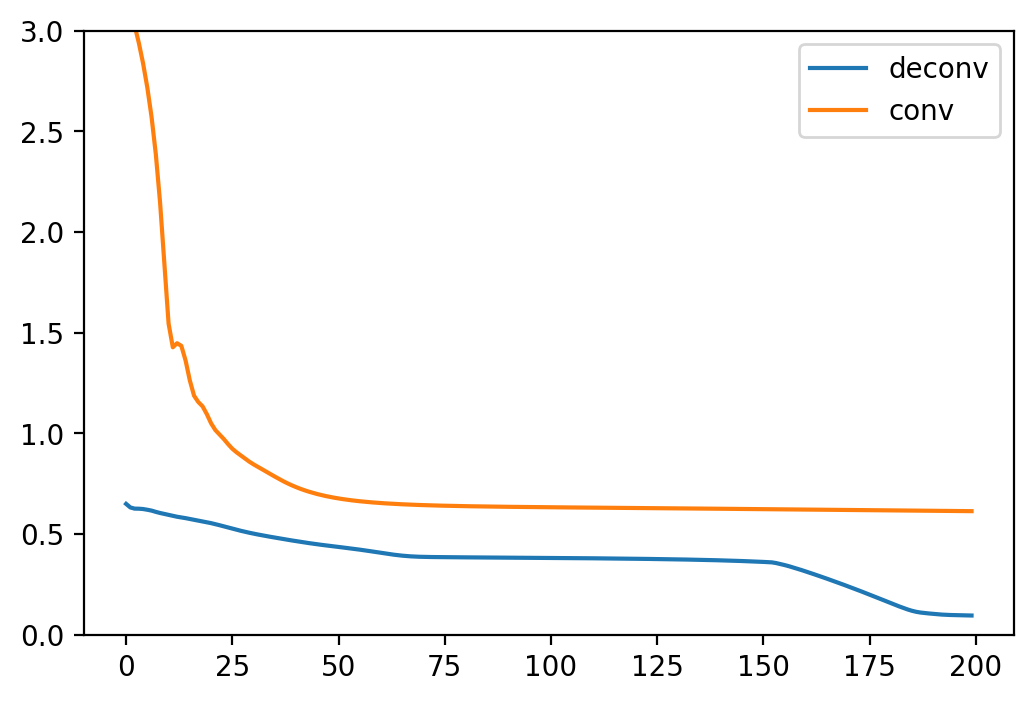

In [ ]:
plt.plot(history['loss'], label='deconv')
plt.plot(history_conv['loss'], label='conv')
plt.ylim([0, 3])
plt.legend()
plt.show()